In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial.transform import Rotation

In [3]:
m = 60
X = np.zeros((m,3)) # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi # uneven distribution
X[:,0], X[:,1] = np.cos(angles), np.sin(angles) * 0.5 # oval
X += 0.28 * np.random.randn(m,3) # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2] # shift a bit

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # select the amount of data (if >= 1 then # number of columns, else % of the data)
X2D = pca.fit_transform(X) # fit ransform the train data, just transform test data

In [5]:
X2D.shape

(60, 2)

In [6]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [7]:
pca.explained_variance_ratio_ # her kecirdiyi vektordan hansi qeder data var faizle onu gosterir. Birinci kecirdiyi vektorda 75%, ikincisinde 15% data var

array([0.7578477 , 0.15186921])

In [8]:
1 - pca.explained_variance_ratio_.sum() # ne qeder data itirdiyimizi bilmek ucun 1 (100%)-den componentlerde olan data miqdarinin cemini cixiriq

0.09028309326742046

In [9]:
# ne qeder data itirmeye haziriqsa o qeder reduction edirik dimensionallay

In [11]:
from sklearn.datasets import fetch_openml

In [12]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto') #parse ozu duzgun bolsun deye verilir

In [13]:
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]

In [14]:
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [15]:
pca = PCA()

In [16]:
pca.fit(X_train)

PCA()

In [17]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # datanin 95% den coxunu saxlayan hell tapir

In [18]:
d

154

In [19]:
pca = PCA(n_components=0.95) 
X_reduced = pca.fit_transform(X_train)

In [20]:
pca.n_components_    # 95% datani saxladigi halda dimensionality-ni necheye eder saldigini gosterir

154

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rfc = RandomForestClassifier()

In [23]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
rfc.score(X_test, y_test)

0.9706

In [25]:
test_reduced = pca.transform(X_test)

In [26]:
rfc.fit(X_reduced, y_train)

RandomForestClassifier()

In [27]:
rfc.score(test_reduced, y_test)

0.9484

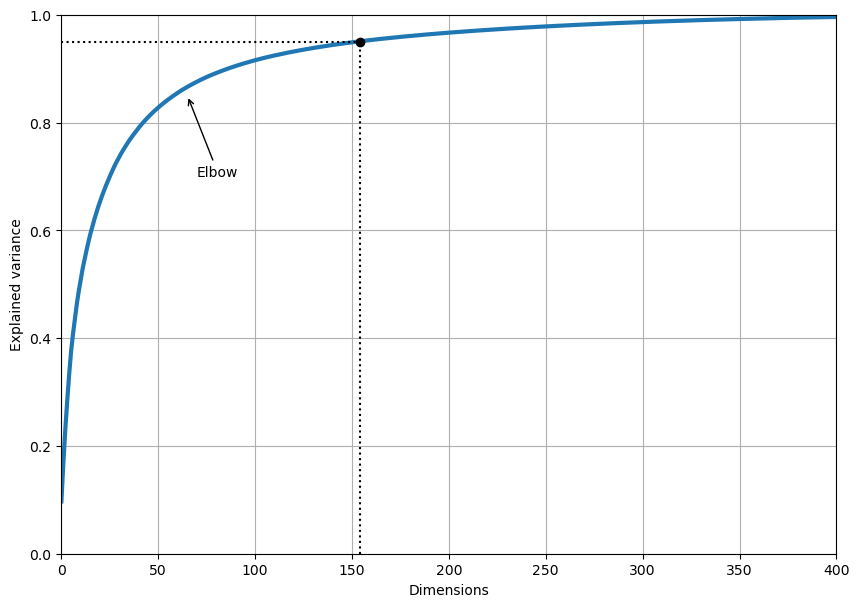

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(cumsum, linewidth=3)
plt.axis([0,400,0,1])
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')
plt.plot([d,d], [0,0.95], 'k:')
plt.plot([0,d], [0.95,0.95], 'k:')
plt.plot(d, 0.95, 'ko')
plt.annotate('Elbow', xy=(65, 0.85), xytext=(70, 0.7),
            arrowprops=dict(arrowstyle='->'))
plt.grid()
plt.show();

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [30]:
pipeline = make_pipeline(PCA(), RandomForestClassifier(random_state=42))
param_grid = {
    "pca__n_components":np.arange(10,80),
    "randomforestclassifier__n_estimators":np.arange(50,500)
}

In [31]:
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=3)
rscv.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 6...
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])})

In [32]:
rscv.best_params_

{'randomforestclassifier__n_estimators': 456, 'pca__n_components': 48}

In [33]:
cumsum[58]

0.8501877639284677

In [34]:
rscv.score(X_test, y_test)

0.8618

In [35]:
print(rscv.best_params_)

{'randomforestclassifier__n_estimators': 456, 'pca__n_components': 48}


In [36]:
rscv.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=48)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=456, random_state=42))])

In [37]:
rscv.best_estimator_.score(X_train, y_train), rscv.best_estimator_.score(X_test, y_test)

(1.0, 0.9578)

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [39]:
sgd_pipeline = make_pipeline(PCA(random_state=42), SGDClassifier(random_state=42))
sgd_param_grid = {
    "pca__n_components":np.arange(10,80)
}

sgd_gscv = GridSearchCV(sgd_pipeline, sgd_param_grid, cv=3)
sgd_gscv.fit(X_train[:1_000], y_train[:1_000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=42))]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [40]:
sgd_gscv.best_params_

{'pca__n_components': 79}

In [41]:
best_model = sgd_gscv.best_estimator_

In [42]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=79, random_state=42)),
                ('sgdclassifier', SGDClassifier(random_state=42))])

In [43]:
best_model.score(X_train, y_train), best_model.score(X_test, y_test)

(0.87875, 0.8864)

In [44]:
# incremental PCA -> EGER pca EDIRIKSE, BUTUN DATA ram-A yigilir. Bele olan halda incremental PCA kimi yollardan istifade edirik
# O melumatlari hisse-hsse email edir

# PCA for Compression

In [45]:
from sklearn.decomposition import IncrementalPCA

In [46]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches): # X_train datasini n_batches sayina bolur
    inc_pca.partial_fit(X_batch)                   # adi fit edende yenisini oyrenir kohneni unudur, amma partial fit olanda oyrendiyinin uzerinden 

In [47]:
X_reduced = inc_pca.transform(X_train)

# LLM

In [48]:
# projection/manifold - 1 pparoach

In [49]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

In [50]:
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

# Mentor Hours

In [51]:
from sklearn.datasets import fetch_openml

In [52]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [53]:
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]

In [54]:
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [55]:
from sklearn.decomposition import PCA

In [56]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

C:\Users\User\AppData\Local\Temp\ipykernel_11108\2350057193.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x=X_reduced[:, 0], y=X_reduced[:, 1], cmap='viridis', alpha=0.7)


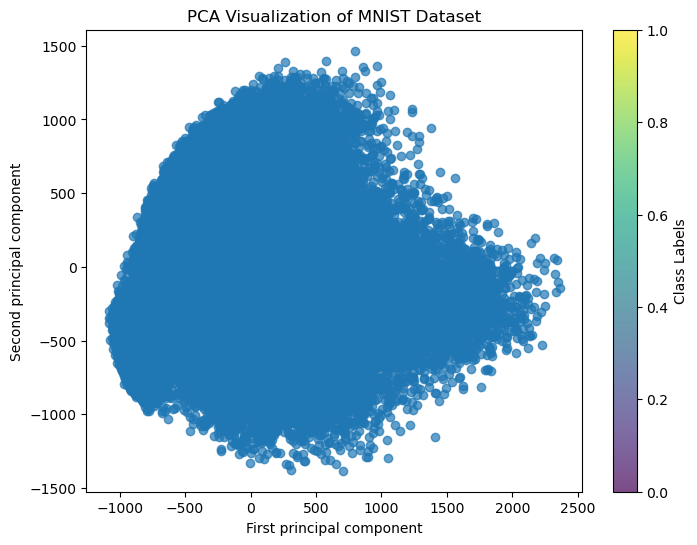

In [57]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x=X_reduced[:, 0], y=X_reduced[:, 1], cmap='viridis', alpha=0.7)
plt.title('PCA Visualization of MNIST Dataset')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(scatter, label='Class Labels')
plt.show();

In [63]:
from sklearn.manifold import TSNE

In [64]:
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]

In [65]:
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [67]:
tsne = TSNE(n_components=2,random_state=42)

In [68]:
X_train_tsne = tsne.fit_transform(X_train)

In [70]:
X_test_tsne = tsne.fit_transform(X_test)

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
tsne_model = LogisticRegression(max_iter=1000)
tsne_model.fit(X_train_tsne, y_train)

LogisticRegression(max_iter=1000)

In [73]:
tsne_model.score(X_test_tsne, y_test)

0.1704

C:\Users\User\AppData\Local\Temp\ipykernel_11108\1408822694.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], cmap='viridis', alpha=0.7)


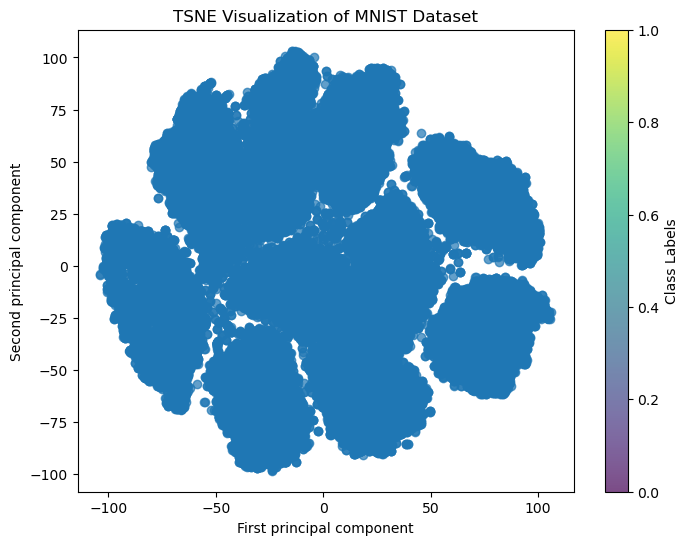

In [74]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], cmap='viridis', alpha=0.7)
plt.title('TSNE Visualization of MNIST Dataset')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(scatter, label='Class Labels')
plt.show();